In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman

from tqdm import tqdm

In [2]:
adjacency_matrix = np.load('adjacency_matrix.npy')

data_recipe = pd.read_json('processed_data.json').reset_index(drop=True)

In [3]:
data_recipe.head(5)

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
0,[Place beans in large pot. Add enough cold wat...,31,2004-08-20 04:00:00,"[Salad, Bean, Herb, Mushroom, Tomato, Side, Ve...",368,8,1.875,White Bean Ragoût with Lemon Oil and Shiitake ...,"[mushroom, onion, chive, bay, wedge, water, ch...",184
1,"[Using on/off turns, coarsely chop cranberries...",0,2004-08-20 04:00:00,"[Condiment/Spread, Sauce, Food Processor, Berr...",313,1,4.375,"Cranberry, Tangerine, and Crystallized-Ginger ...","[orange, sugar, ginger, tangerine, piece, marm...",31
2,[In a skillet cook the bell pepper in the oil ...,50,2004-08-20 04:00:00,"[Blender, Food Processor, Herb, Tomato, Bake, ...",780,37,4.375,"Herbed Crepes with Ricotta, Green Bell Pepper,...","[salt, parsley, garlic, mixture, crêpes, cayen...",2053
3,"[In a large skillet cook the onion, the scalli...",34,2004-08-20 04:00:00,"[Milk/Cream, Egg, Mushroom, Onion, Side, Bake,...",610,34,3.750,Vegetable and Cheese Strata,"[mushroom, onion, strip, cube, oil, scallion, ...",990
4,"[Preheat the oven to 350°F., Remove the wings...",2,2015-12-01 20:30:00,"[HarperCollins, Soup/Stew, Chicken, Carrot, On...",35,3,0.000,Chicken Bone Broth,"[onion, water, cider, cube, bay, carrot, vineg...",55


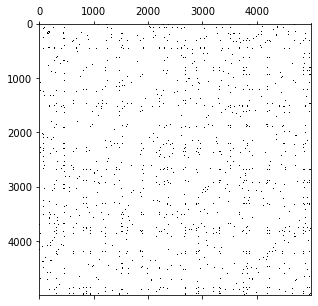

In [4]:
plt.figure(figsize=(5,5))
plt.spy(adjacency_matrix)
plt.show()

In [5]:
data_recipe.rating.value_counts()

4.375    2024
3.750    1337
5.000     666
0.000     378
3.125     375
2.500     147
1.250      41
1.875      32
Name: rating, dtype: int64

In [6]:
# Helper function for printing various graph properties
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [24]:
graph = nx.from_numpy_array(adjacency_matrix[:500,:500])

In [25]:
describe_graph(graph)

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 2440
Average degree:   9.7600
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0196
Global clustering coefficient aka Transitivity: 0.2805


In [26]:
node_label_mapping = dict(zip(range(5000), data_recipe.title))

In [27]:
# add node attributes
nx.set_node_attributes(graph, data_recipe['protein'].to_dict(), 'protein')
nx.set_node_attributes(graph, data_recipe['fat'].to_dict(), 'fat')
nx.set_node_attributes(graph, data_recipe['sodium'].to_dict(), 'sodium')
nx.set_node_attributes(graph, data_recipe['calories'].to_dict(), 'calories')
nx.set_node_attributes(graph, data_recipe['rating'].to_dict(), 'rating')

In [28]:
print(node_label_mapping[0])
print(graph.node[0])

White Bean Ragoût with Lemon Oil and Shiitake Mushrooms 
{'protein': 8, 'fat': 31, 'sodium': 184, 'calories': 368, 'rating': 1.875}


In [29]:
# Helper function for visualizing signal on the graph
def visualize_graph(G, signal, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    plt.figure(figsize=(15,8))
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=[G.nodes[n][signal] for n in G.nodes()], node_shape=node_shape)
    plt.colorbar(nc)
    plt.axis('off')

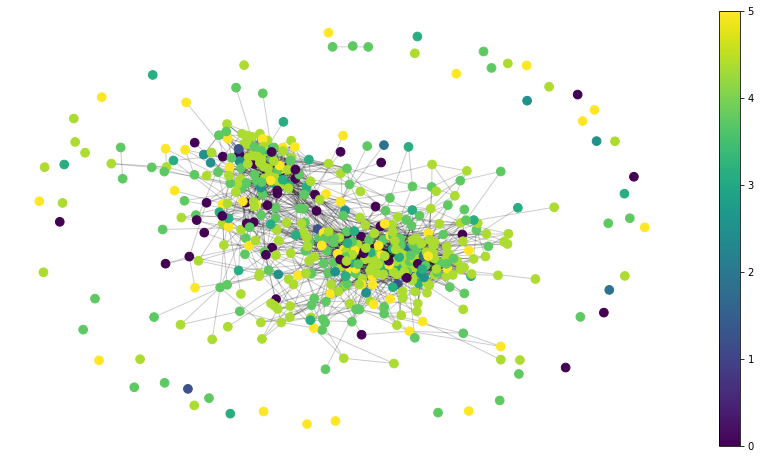

In [37]:
visualize_graph(graph,'rating',False, k=0.1, alpha=0.2, node_shape='.')

In [40]:
partition = community_louvain.best_partition(graph)
# add it as an attribute to the nodes
for n in graph.nodes:
    graph.nodes[n]["louvain"] = partition[n]

/Users/davitmartirosyan/anaconda3/envs/NTDS/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


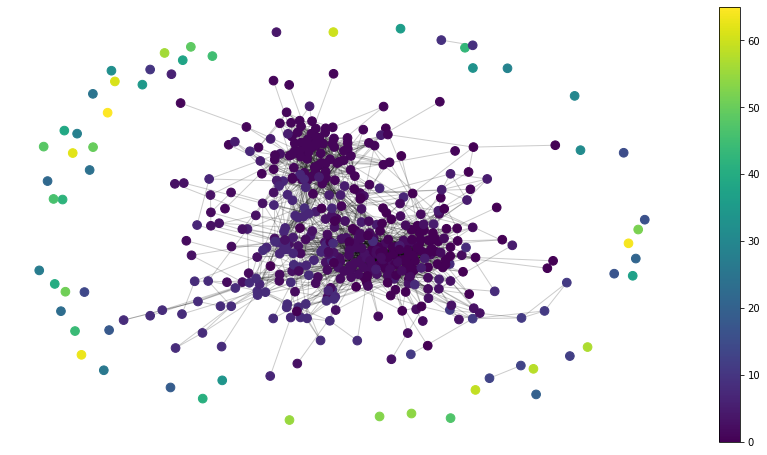

In [44]:
visualize_graph(graph,'louvain',False, k=0.1, alpha=0.2, node_shape='.')